In [1]:
from microstruktur.signal_models import dispersed_models, gaussian_models
from microstruktur.core import modeling_framework, acquisition_scheme
from microstruktur.utils import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

## Get an intial guess for orientation using Dipy's DTI

In [3]:
from dipy.reconst import dti

gtab = acquisition_scheme.gtab_mipy2dipy(scheme)
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

In [4]:
mu_parallel_cart = tenfit_parallel.directions.squeeze()
mu_dispersed_cart = tenfit_dispersed.directions.squeeze()

In [5]:
from microstruktur.utils.utils import cart2sphere
mu_parallel = utils.cart2mu(mu_parallel_cart)
mu_dispersed = utils.cart2mu(mu_dispersed_cart)

## Generate NODDI-Watson model

In [6]:
from microstruktur.utils.utils import parameter_equality, T1_tortuosity

ball = gaussian_models.G3Ball()
dispersed_stick = dispersed_models.SD1C1WatsonDispersedStick()
dispersed_zeppelin = dispersed_models.SD1G4WatsonDispersedZeppelin()

parameter_links = [
    (  # tortuosity assumption
        dispersed_zeppelin, 'lambda_perp',
        T1_tortuosity, [
            (None, 'partial_volume_1'),
            (dispersed_stick, 'lambda_par')
        ]
    ),
    (  # equal parallel diffusivities
         dispersed_zeppelin, 'lambda_par',
         parameter_equality, [
            (dispersed_stick, 'lambda_par')
        ]
     ),
    (  # equal dispersion
         dispersed_zeppelin, 'kappa',
         parameter_equality, [
            (dispersed_stick, 'kappa')
        ]
     ),
    (  # equal orientation
         dispersed_zeppelin, 'mu',
         parameter_equality, [
            (dispersed_stick, 'mu')
        ]
     )
]


NODDI_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[ball, dispersed_stick, dispersed_zeppelin],
    parameter_links=parameter_links
)

# Fix parallel diffusivity and isotropic diffusivity
NODDI_mod.optimized_parameters['SD1C1WatsonDispersedStick_1_lambda_par'] = False
NODDI_mod.optimized_parameters['G3Ball_1_lambda_iso'] = False

## Fit NODDI to data

In [7]:
param_parallel_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1C1WatsonDispersedStick_1_mu=mu_parallel,
    SD1C1WatsonDispersedStick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)
param_dispersed_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1C1WatsonDispersedStick_1_mu=mu_dispersed,
    SD1C1WatsonDispersedStick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)

SD1C1WatsonDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD1C1WatsonDispersedStick_1_mu successfully set.
SD1C1WatsonDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD1C1WatsonDispersedStick_1_mu successfully set.


In [8]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit = NODDI_mod.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0)

# fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
NODDI_fit_dispersed = NODDI_mod.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 120.92128396 seconds.
Average of 0.366428133213 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 931.460577965 seconds.
Average of 0.313623090224 seconds per voxel.


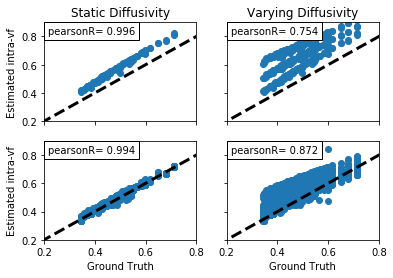

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

saved_data.visualize_correlation_camino_and_estimated_fractions(
    NODDI_fit.fitted_parameters['partial_volume_1'].squeeze(),
    NODDI_fit_dispersed.fitted_parameters['partial_volume_1'].squeeze())

# Human Connectome Project Example

In [10]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

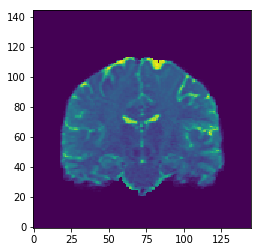

In [11]:
plt.imshow(data[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [12]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data, mask=data[..., 0]>0)

In [13]:
mu_cart = tenfit.directions[..., 0, :]
mu = utils.cart2mu(mu_cart)

param_x0 = NODDI_mod.parameter_initial_guess_to_parameter_vector(
    SD1C1WatsonDispersedStick_1_mu=mu,
    SD1C1WatsonDispersedStick_1_lambda_par=1.7e-9,
    G3Ball_1_lambda_iso=3.0e-9
)

SD1C1WatsonDispersedStick_1_lambda_par successfully set.
G3Ball_1_lambda_iso successfully set.
SD1C1WatsonDispersedStick_1_mu successfully set.


/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:331: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


## Fit NODDI to HCP data

In [14]:
NODDI_fit_hcp = NODDI_mod.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 2466.70414901 seconds.
Average of 0.301516214278 seconds per voxel.


## Visualize results

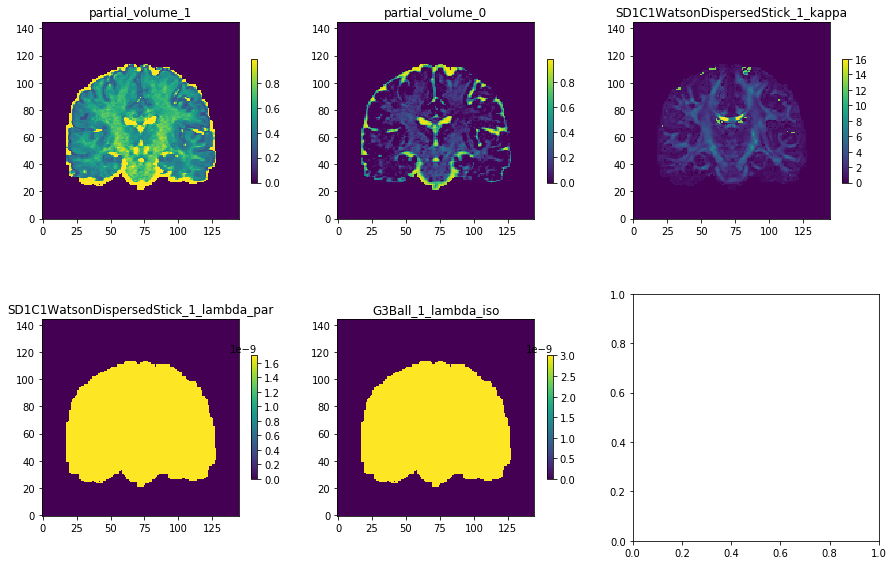

In [24]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Above we see the familiar maps. Remember that partial_volume_0 and partial_volume_1 represent fractions of models in the order they were given to the MultiCompartmentMicrostructureModel object. In this case, 0 represents the fraction of Ball (CSF), and the 1 represents the Stick (intra-axonal).

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:897: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:878: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


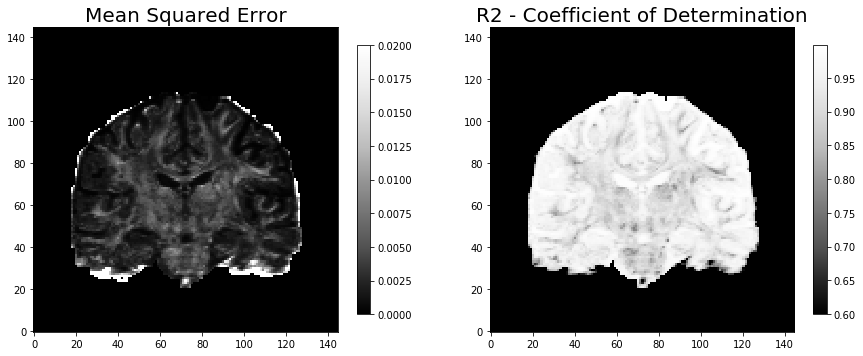

In [16]:
mse = NODDI_fit_hcp.mean_squared_error(data)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in NODDI-Watson we can see clearly see the structure of the different brain areas. This means that the model cannot fit the diffusion signal equally well in all brainn areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.